# Fossil Fuel Costs and Electricity Price Reconstruction

This notebook calculates the Short Run Marginal Costs (SRMC) of generating
electricity using hard coal and fossil gas, then uses a simplified merit
order model to reconstruct wholesale electricity prices.

## Approach

1. Calculate **SRMC** for coal and gas power plants from commodity prices

2. Calculate **Fossil Residual Load**: the demand that must be met by fossil plants
   after accounting for renewables and baseload generation

$$RL_{fossil} = \text{Load} - (\text{Wind} + \text{Solar}) - (\text{Nuclear} + \text{Biomass} + \text{Hydro}_{RoR})$$

3. Determine which fossil fuel (coal or gas) is cheaper based on SRMC

4. Assign price based on merit order:
   - If $RL_{fossil} \leq \text{cheaper capacity}$: price = cheaper SRMC
   - If $RL_{fossil} > \text{cheaper capacity}$: price = more expensive SRMC

5. Compare reconstructed prices with actual market prices

## Short Run Marginal Costs (SRMC)

The **Short Run Marginal Cost (SRMC)** represents the variable cost of producing
one additional MWh of electricity from a power plant. It determines the merit
order position of generators in wholesale electricity markets.

### Components of SRMC

SRMC consists of three main components:

1. **Fuel costs** - The cost of the primary fuel (gas or coal) needed to
   generate electricity, adjusted for plant efficiency.

2. **Carbon costs** - The cost of CO2 emissions under the EU Emissions Trading
   Scheme (EU ETS), based on the carbon intensity of the fuel.

3. **Variable O&M costs** - Operating and maintenance costs that vary with
   electricity output.

### Price References

**Fossil Gas:**
- Dutch Title Transfer Facility (TTF) is the benchmark for gas traded in Europe
- Other European hubs (CEGH VTP, THE, PSV, etc.) trade at spreads to TTF
- Prices sourced from commodity exchanges (e.g., ICE, EEX)

**Hard Coal:**
- API 2 Rotterdam is the benchmark for coal imported into Northwest Europe
- Front month settlement prices in USD/metric ton
- Thermal content approximately 6,000 kcal/kg (NAR)

**Carbon:**
- EU ETS allowance prices (EUA) for the front December contract
- Prices in EUR per tonne CO2

### Calculation Assumptions

| Parameter | Hard Coal | Fossil Gas |
|-----------|-----------|------------|
| Efficiency (HHV) | 40% | 50% |
| Carbon intensity | 0.83 tCO2/MWh | 0.37 tCO2/MWh |
| Variable O&M | €2/MWh | €2/MWh |

The carbon intensity values represent emissions per MWh of electricity generated,
accounting for the power plant efficiency.

### Why SRMC Matters

In liberalized electricity markets, generators bid close to their marginal cost.
The SRMC comparison between coal and gas determines:

- **Fuel switching** - When gas SRMC falls below coal, utilities switch from
  coal to gas, reducing emissions
- **Price formation** - The highest SRMC plant needed to meet demand often
  sets the wholesale electricity price
- **Investment signals** - Persistent SRMC relationships influence new build
  decisions and plant retirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from woe.paths import ProjPaths

## SRMC Calculation Parameters

In [2]:
# Power plant efficiency rates (Higher Heating Value / Gross Calorific Value)
COAL_EFFICIENCY = 0.40  # 40%
GAS_EFFICIENCY = 0.50  # 50%

# Carbon intensity (tCO2 per MWh of electricity generated)
COAL_CARBON_INTENSITY = 0.83  # tCO2/MWh
GAS_CARBON_INTENSITY = 0.37  # tCO2/MWh

# Variable Operating and Maintenance costs (EUR/MWh)
VOM_COST = 2.0

# Coal thermal content (MWh per metric ton)
# API 2 coal specification: 6,000 kcal/kg NAR
# 6,000 kcal/kg = 6,000,000 kcal/t ÷ 860,421 kcal/MWh ≈ 6.98 MWh/t
COAL_THERMAL_CONTENT = 6.98  # MWh/t

# EUR/USD exchange rate (approximate)
EURUSD_RATE = 1.08

## Load Data

In [3]:
paths = ProjPaths()

# Load generation and consumption data
print("Loading SMARD data...")
solar = pd.read_parquet(paths.smard_solar_file)
wind_onshore = pd.read_parquet(paths.smard_wind_onshore_file)
wind_offshore = pd.read_parquet(paths.smard_wind_offshore_file)
total_load = pd.read_parquet(paths.smard_total_load_file)
prices = pd.read_parquet(paths.smard_prices_file)
capacities = pd.read_parquet(paths.smard_capacities_file)

print(f"Generation data: {solar.index.min()} to {solar.index.max()}")
print(f"Prices: {prices.index.min()} to {prices.index.max()}")
print(f"Capacities: {capacities.index.min()} to {capacities.index.max()}")

Loading SMARD data...
Generation data: 2016-12-31 00:00:00 to 2026-02-05 13:00:00
Prices: 2018-10-01 00:00:00 to 2026-02-09 23:00:00
Capacities: 2015-01-01 00:00:00 to 2026-12-01 00:00:00


### Baseload Generation Data

Nuclear, biomass, and hydro generation data for the fossil residual load calculation.

In [4]:
print("Loading baseload generation data...")
nuclear = pd.read_parquet(paths.smard_nuclear_file)
biomass = pd.read_parquet(paths.smard_biomass_file)
hydro = pd.read_parquet(paths.smard_hydro_file)

print(f"Nuclear: {len(nuclear)} records")
print(f"Biomass: {len(biomass)} records")
print(f"Hydro: {len(hydro)} records")

Loading baseload generation data...
Nuclear: 46735 records
Biomass: 79788 records
Hydro: 79779 records


### Commodity Prices

In [5]:
def load_investing_com_csv(filepath: str) -> pd.Series:
    """Load price data from Investing.com CSV export."""
    df = pd.read_csv(
        filepath,
        encoding="utf-8-sig",
        parse_dates=["Date"],
        dayfirst=False,
    )
    df = df.set_index("Date").sort_index()
    return df["Price"]

In [6]:
# Load commodity prices
print("Loading commodity prices...")
gas_df = pd.read_parquet(paths.ttf_gas_prices_file)
gas_prices = gas_df["Close"].rename("gas_price")

coal_prices = load_investing_com_csv(paths.rotterdam_coal_prices_file).rename(
    "coal_price"
)

carbon_prices = load_investing_com_csv(paths.eu_carbon_prices_file).rename(
    "carbon_price"
)

print(f"Gas prices: {gas_prices.index.min()} to {gas_prices.index.max()}")
print(f"Coal prices: {coal_prices.index.min()} to {coal_prices.index.max()}")
print(f"Carbon prices: {carbon_prices.index.min()} to {carbon_prices.index.max()}")

Loading commodity prices...
Gas prices: 2017-10-23 00:00:00 to 2026-02-06 00:00:00
Coal prices: 2017-01-03 00:00:00 to 2026-02-06 00:00:00
Carbon prices: 2017-01-02 00:00:00 to 2026-02-06 00:00:00


## Calculate SRMC

### Gas SRMC
$$\text{Gas SRMC} = \frac{\text{Gas Price}}{\text{Efficiency}} + \text{Carbon Intensity} \times \text{Carbon Price} + \text{VOM}$$

### Coal SRMC
$$\text{Coal SRMC} = \frac{\text{Coal Price (EUR/MWh)}}{\text{Efficiency}} + \text{Carbon Intensity} \times \text{Carbon Price} + \text{VOM}$$

Note: Coal prices in USD/t need to be converted to EUR/MWh using:
- Exchange rate (USD/EUR)
- Thermal content (MWh/t)

In [7]:
# Combine commodity prices (daily)
commodity_prices = pd.concat(
    [gas_prices, coal_prices, carbon_prices], axis=1, join="inner"
)
commodity_prices = commodity_prices.ffill()

# Convert coal from USD/t to EUR/MWh
coal_eur_mwh = commodity_prices["coal_price"] / EURUSD_RATE / COAL_THERMAL_CONTENT

# Calculate SRMC components
gas_fuel_cost = commodity_prices["gas_price"] / GAS_EFFICIENCY
coal_fuel_cost = coal_eur_mwh / COAL_EFFICIENCY

gas_carbon_cost = GAS_CARBON_INTENSITY * commodity_prices["carbon_price"]
coal_carbon_cost = COAL_CARBON_INTENSITY * commodity_prices["carbon_price"]

# Total SRMC (daily)
srmc_daily = pd.DataFrame(index=commodity_prices.index)
srmc_daily["gas_srmc"] = gas_fuel_cost + gas_carbon_cost + VOM_COST
srmc_daily["coal_srmc"] = coal_fuel_cost + coal_carbon_cost + VOM_COST

# Store components for analysis
srmc_daily["gas_fuel_cost"] = gas_fuel_cost
srmc_daily["gas_carbon_cost"] = gas_carbon_cost
srmc_daily["coal_fuel_cost"] = coal_fuel_cost
srmc_daily["coal_carbon_cost"] = coal_carbon_cost

print("SRMC Summary (EUR/MWh):")
print(srmc_daily[["gas_srmc", "coal_srmc"]].describe().round(2))

SRMC Summary (EUR/MWh):
       gas_srmc  coal_srmc
count   2075.00    2075.00
mean     105.26      85.19
std       90.38      41.89
min       17.17      31.19
25%       44.53      44.46
50%       89.41      91.70
75%      115.54     107.87
max      713.81     206.47


## SRMC Time Series

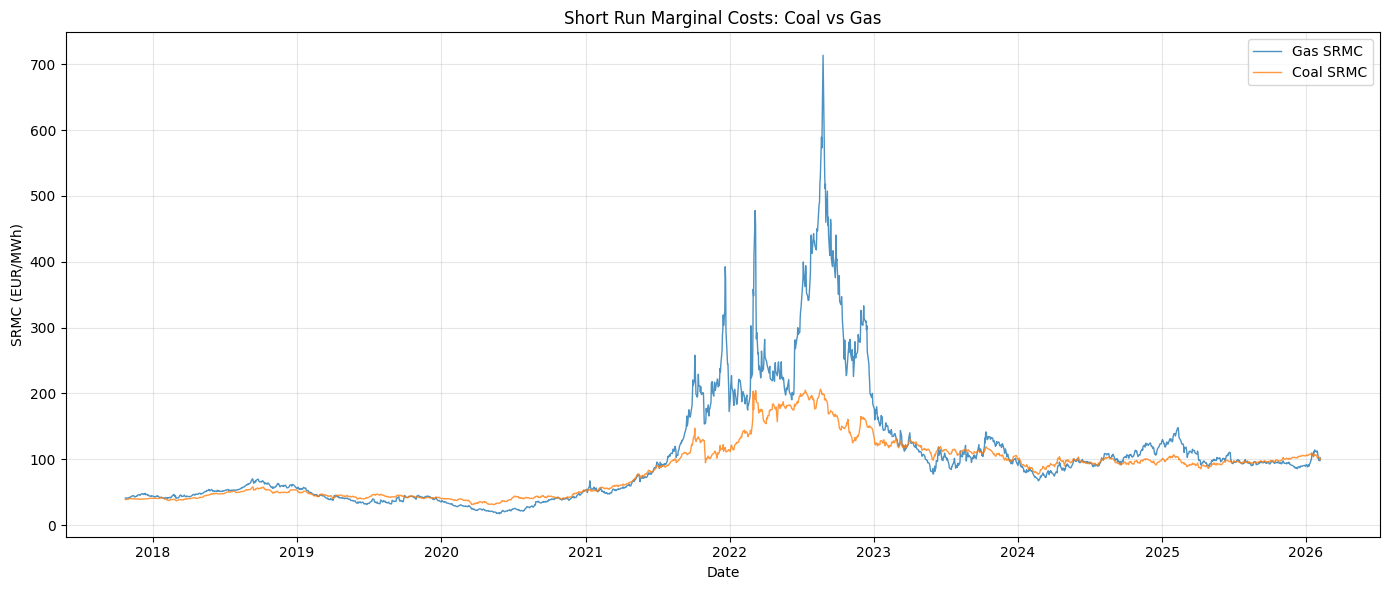

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(srmc_daily.index, srmc_daily["gas_srmc"], label="Gas SRMC", linewidth=1, alpha=0.8)
ax.plot(srmc_daily.index, srmc_daily["coal_srmc"], label="Coal SRMC", linewidth=1, alpha=0.8)

ax.set_xlabel("Date")
ax.set_ylabel("SRMC (EUR/MWh)")
ax.set_title("Short Run Marginal Costs: Coal vs Gas")
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

## Monthly Average SRMC

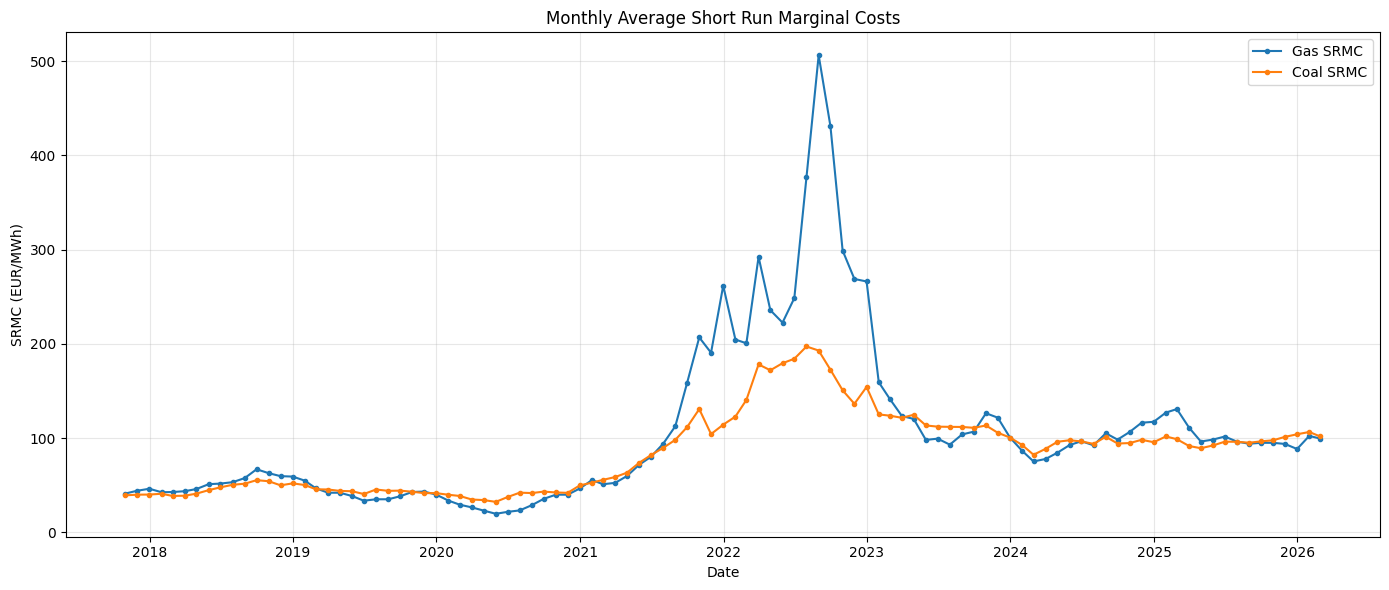

In [9]:
monthly_srmc = srmc_daily[["gas_srmc", "coal_srmc"]].resample("ME").mean()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    monthly_srmc.index,
    monthly_srmc["gas_srmc"],
    label="Gas SRMC",
    marker="o",
    markersize=3,
)
ax.plot(
    monthly_srmc.index,
    monthly_srmc["coal_srmc"],
    label="Coal SRMC",
    marker="o",
    markersize=3,
)

ax.set_xlabel("Date")
ax.set_ylabel("SRMC (EUR/MWh)")
ax.set_title("Monthly Average Short Run Marginal Costs")
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

## Fuel Switching Indicator

When gas SRMC is lower than coal SRMC, it is economically favorable to dispatch
gas plants over coal plants, leading to lower emissions. This "fuel switching"
is a key mechanism for carbon price effectiveness.

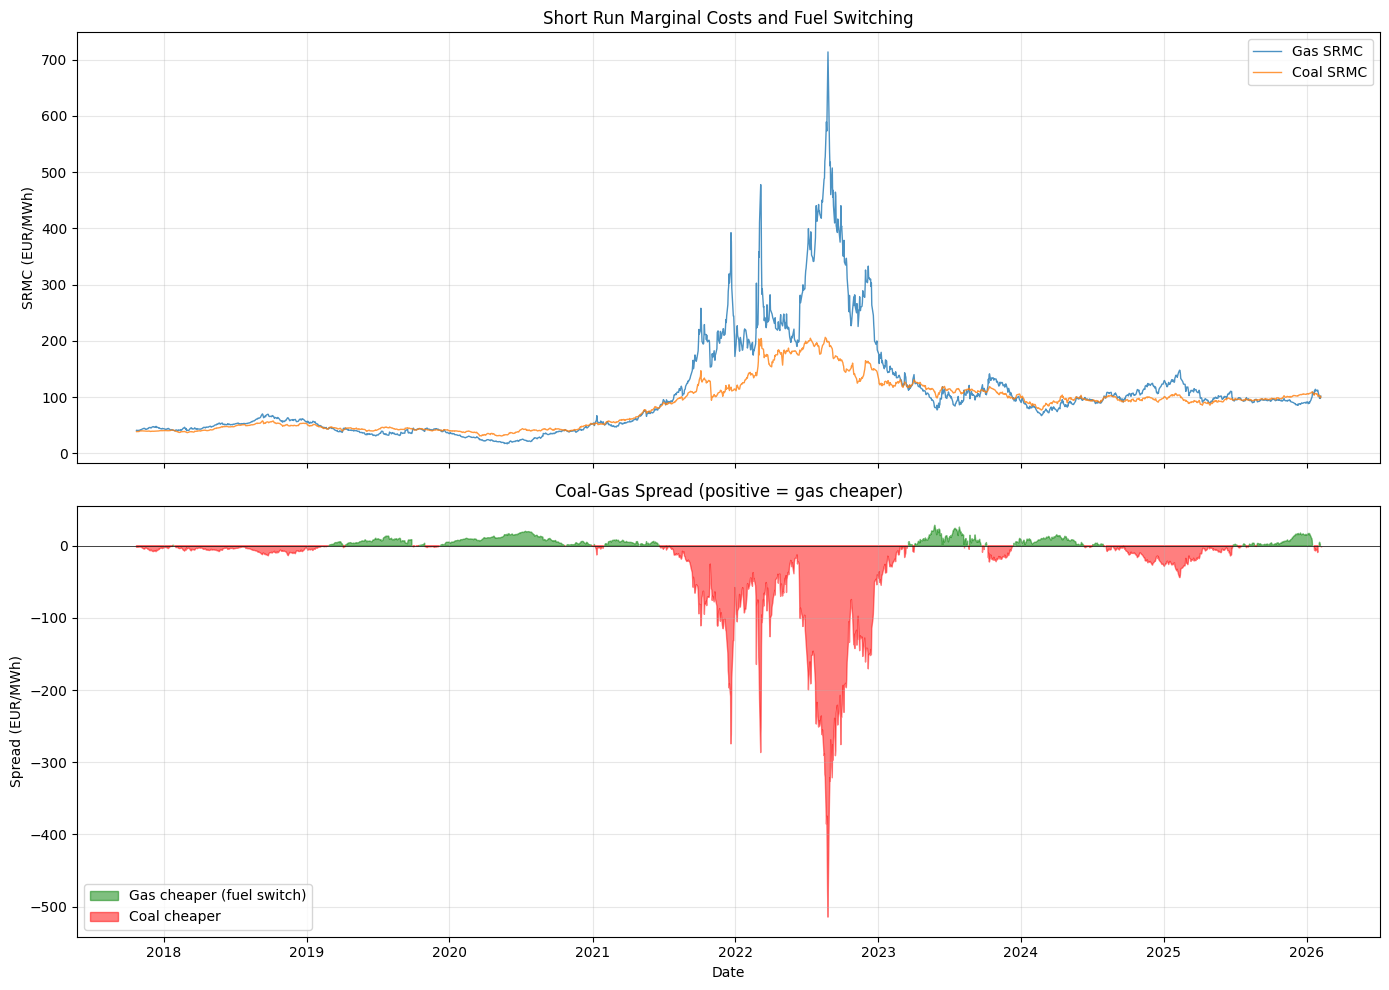

In [10]:
# Calculate the spread (positive = gas cheaper than coal)
srmc_daily["spread"] = srmc_daily["coal_srmc"] - srmc_daily["gas_srmc"]

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# SRMC comparison
ax1 = axes[0]
ax1.plot(srmc_daily.index, srmc_daily["gas_srmc"], label="Gas SRMC", linewidth=1, alpha=0.8)
ax1.plot(srmc_daily.index, srmc_daily["coal_srmc"], label="Coal SRMC", linewidth=1, alpha=0.8)
ax1.set_ylabel("SRMC (EUR/MWh)")
ax1.set_title("Short Run Marginal Costs and Fuel Switching")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Spread (coal - gas)
ax2 = axes[1]
ax2.fill_between(
    srmc_daily.index,
    srmc_daily["spread"],
    0,
    where=srmc_daily["spread"] >= 0,
    color="green",
    alpha=0.5,
    label="Gas cheaper (fuel switch)",
)
ax2.fill_between(
    srmc_daily.index,
    srmc_daily["spread"],
    0,
    where=srmc_daily["spread"] < 0,
    color="red",
    alpha=0.5,
    label="Coal cheaper",
)
ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
ax2.set_xlabel("Date")
ax2.set_ylabel("Spread (EUR/MWh)")
ax2.set_title("Coal-Gas Spread (positive = gas cheaper)")
ax2.legend()
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

## SRMC Cost Components

Breaking down the SRMC into its fuel and carbon cost components shows the
relative importance of each driver.

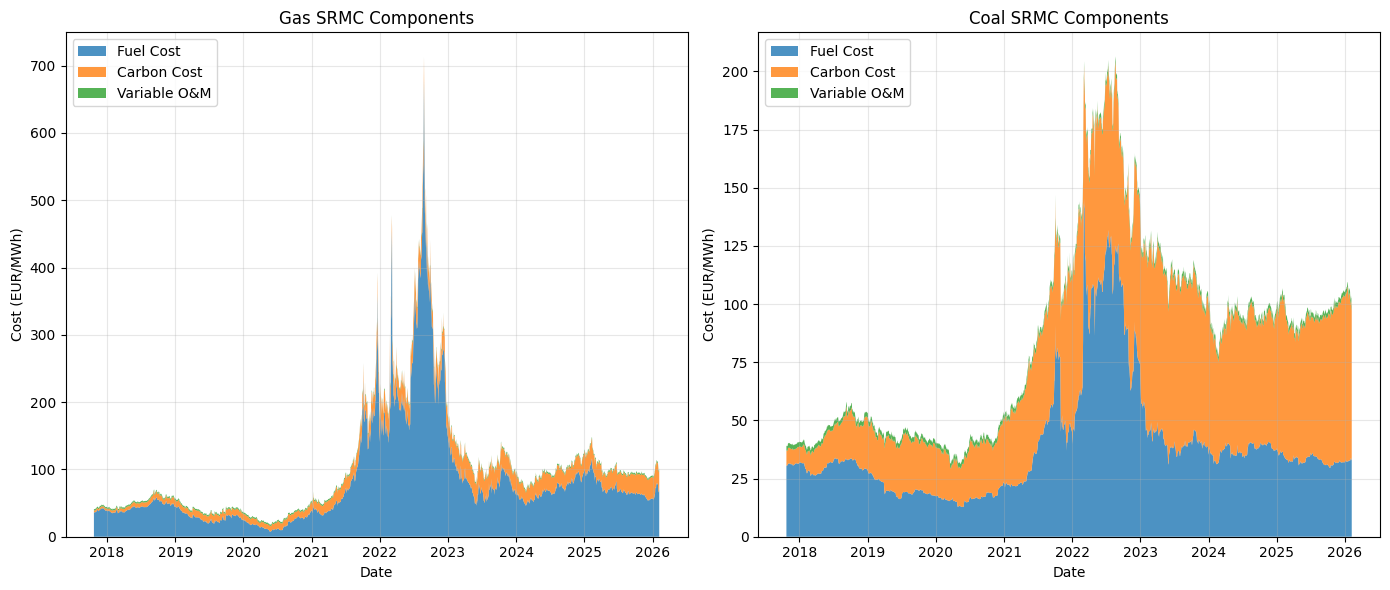

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gas SRMC components
ax1 = axes[0]
ax1.stackplot(
    srmc_daily.index,
    srmc_daily["gas_fuel_cost"],
    srmc_daily["gas_carbon_cost"],
    [VOM_COST] * len(srmc_daily),
    labels=["Fuel Cost", "Carbon Cost", "Variable O&M"],
    alpha=0.8,
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cost (EUR/MWh)")
ax1.set_title("Gas SRMC Components")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

# Coal SRMC components
ax2 = axes[1]
ax2.stackplot(
    srmc_daily.index,
    srmc_daily["coal_fuel_cost"],
    srmc_daily["coal_carbon_cost"],
    [VOM_COST] * len(srmc_daily),
    labels=["Fuel Cost", "Carbon Cost", "Variable O&M"],
    alpha=0.8,
)
ax2.set_xlabel("Date")
ax2.set_ylabel("Cost (EUR/MWh)")
ax2.set_title("Coal SRMC Components")
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

## Combine All Data

Align all data to hourly resolution by forward-filling daily/monthly data.

In [12]:
# Combine generation data into single DataFrame
df = pd.concat(
    [
        solar.rename(columns={solar.columns[0]: "solar"}),
        wind_onshore.rename(columns={wind_onshore.columns[0]: "wind_onshore"}),
        wind_offshore.rename(columns={wind_offshore.columns[0]: "wind_offshore"}),
        total_load.rename(columns={total_load.columns[0]: "total_load"}),
        prices.rename(columns={prices.columns[0]: "price"}),
        nuclear.rename(columns={nuclear.columns[0]: "nuclear"}),
        biomass.rename(columns={biomass.columns[0]: "biomass"}),
        hydro.rename(columns={hydro.columns[0]: "hydro"}),
    ],
    axis=1,
)

# Drop rows with missing generation/price data
df = df.dropna()
print(f"Combined hourly data: {len(df)} records")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Combined hourly data: 46732 records
Date range: 2018-10-01 01:00:00 to 2024-01-30 11:00:00


/tmp/ipykernel_234152/3273808695.py:2: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  df = pd.concat(


In [13]:
# Forward-fill SRMC to hourly
# Normalize index to date only for merging
df["date"] = df.index.date
srmc_daily_reset = srmc_daily.copy()
srmc_daily_reset.index = srmc_daily_reset.index.date

df = df.merge(
    srmc_daily_reset[["gas_srmc", "coal_srmc"]],
    left_on="date",
    right_index=True,
    how="left",
)
df = df.drop(columns=["date"])

# Forward-fill any gaps in SRMC
df["gas_srmc"] = df["gas_srmc"].ffill()
df["coal_srmc"] = df["coal_srmc"].ffill()

# Drop rows without SRMC data
df = df.dropna(subset=["gas_srmc", "coal_srmc"])
print(f"After SRMC merge: {len(df)} records")

After SRMC merge: 46732 records


In [14]:
# Forward-fill capacities to hourly
# Capacities are monthly, so we need to reindex and forward-fill
capacities_hourly = capacities.reindex(df.index, method="ffill")

# Add relevant capacity columns to main DataFrame
df["capacity_coal"] = (
    capacities_hourly["brown_coal"].fillna(0)
    + capacities_hourly["hard_coal"].fillna(0)
)
df["capacity_gas"] = capacities_hourly["natural_gas"].fillna(0)

# Drop rows without capacity data
df = df.dropna(subset=["capacity_coal", "capacity_gas"])
print(f"After capacity merge: {len(df)} records")
print(f"Final date range: {df.index.min()} to {df.index.max()}")

After capacity merge: 46732 records
Final date range: 2018-10-01 01:00:00 to 2024-01-30 11:00:00


## Calculate Fossil Residual Load

$$RL_{fossil} = \text{Load} - (\text{Wind} + \text{Solar}) - (\text{Nuclear} + \text{Biomass} + \text{Hydro})$$

In [15]:
# Calculate components
df["wind"] = df["wind_onshore"] + df["wind_offshore"]
df["renewables"] = df["solar"] + df["wind"]
df["baseload"] = df["nuclear"] + df["biomass"] + df["hydro"]

# Residual load for fossil plants
df["rl_fossil"] = df["total_load"] - df["renewables"] - df["baseload"]

# Standard residual load (for comparison)
df["residual_load"] = df["total_load"] - df["renewables"]

print("Fossil Residual Load Statistics (MW):")
print(df["rl_fossil"].describe().round(0))

# Count negative fossil residual load hours
negative_hours = (df["rl_fossil"] < 0).sum()
print(f"\nHours with negative RL_fossil: {negative_hours} ({100*negative_hours/len(df):.1f}%)")

Fossil Residual Load Statistics (MW):
count    46732.0
mean     24404.0
std      12476.0
min     -12992.0
25%      15884.0
50%      24657.0
75%      33056.0
max      62743.0
Name: rl_fossil, dtype: float64

Hours with negative RL_fossil: 1173 (2.5%)


## Reconstruct Prices Using Merit Order

For each hour:
1. Determine which fuel (coal or gas) has lower SRMC
2. If fossil residual load can be met by cheaper fuel capacity alone, use cheaper SRMC
3. Otherwise, use more expensive SRMC as the marginal price

In [16]:
def reconstruct_price(row):
    """Reconstruct electricity price based on merit order."""
    rl_fossil = row["rl_fossil"]
    gas_srmc = row["gas_srmc"]
    coal_srmc = row["coal_srmc"]
    capacity_coal = row["capacity_coal"]
    capacity_gas = row["capacity_gas"]

    # Handle negative residual load (renewable surplus)
    if rl_fossil <= 0:
        return 0.0  # Price floor at zero for simplicity

    # Determine merit order based on SRMC
    if coal_srmc <= gas_srmc:
        # Coal is cheaper
        cheaper_srmc = coal_srmc
        expensive_srmc = gas_srmc
        cheaper_capacity = capacity_coal
    else:
        # Gas is cheaper
        cheaper_srmc = gas_srmc
        expensive_srmc = coal_srmc
        cheaper_capacity = capacity_gas

    # Assign price based on which fuel is marginal
    if rl_fossil <= cheaper_capacity:
        return cheaper_srmc
    else:
        return expensive_srmc

In [17]:
# Apply reconstruction
print("Reconstructing prices...")
df["price_reconstructed"] = df.apply(reconstruct_price, axis=1)

print("\nReconstructed Price Statistics (EUR/MWh):")
print(df["price_reconstructed"].describe().round(2))

print("\nActual Price Statistics (EUR/MWh):")
print(df["price"].describe().round(2))

Reconstructing prices...



Reconstructed Price Statistics (EUR/MWh):
count    46732.00
mean        88.10
std         63.73
min          0.00
25%         40.98
50%         68.72
75%        120.84
max        713.81
Name: price_reconstructed, dtype: float64

Actual Price Statistics (EUR/MWh):
count    46732.00
mean        96.56
std        102.86
min       -500.00
25%         35.87
50%         58.65
75%        117.01
max        871.00
Name: price, dtype: float64


## Compare Reconstructed vs Actual Prices

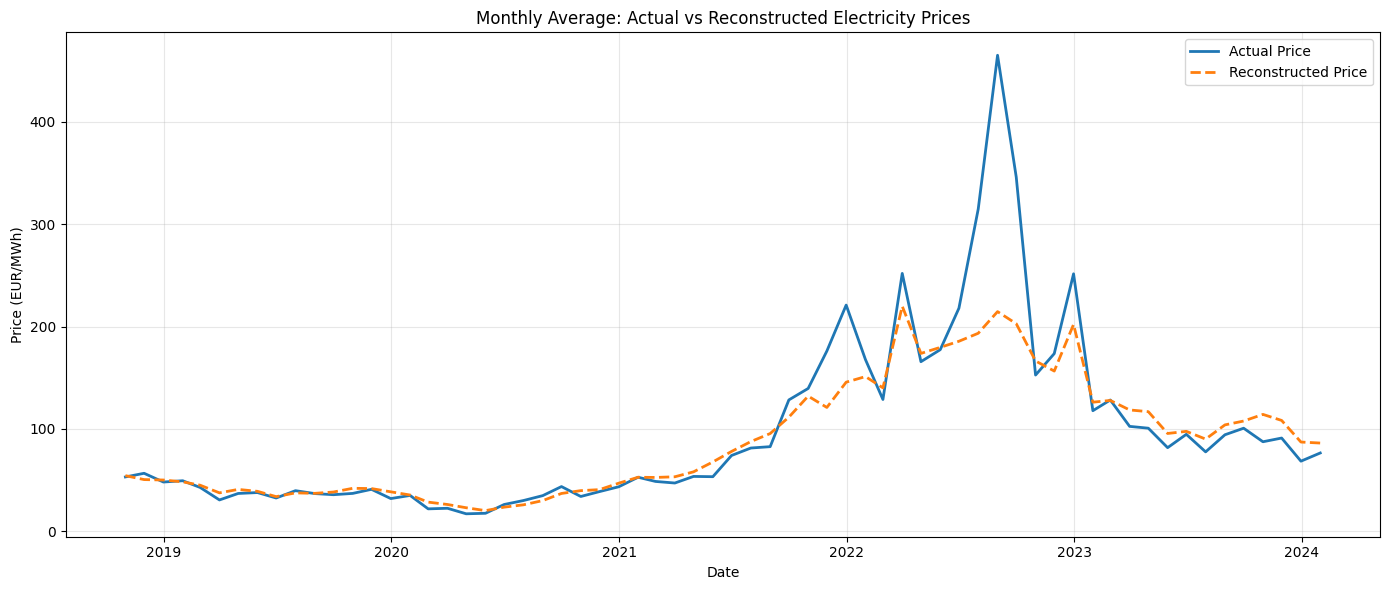

In [18]:
# Time series comparison (monthly averages)
monthly = df[["price", "price_reconstructed"]].resample("ME").mean()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(monthly.index, monthly["price"], label="Actual Price", linewidth=2)
ax.plot(
    monthly.index,
    monthly["price_reconstructed"],
    label="Reconstructed Price",
    linewidth=2,
    linestyle="--",
)

ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR/MWh)")
ax.set_title("Monthly Average: Actual vs Reconstructed Electricity Prices")
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

## Scatterplots

In [19]:
# Sample data for scatterplots (performance)
sample_size = min(50000, len(df))
sample = df.sample(sample_size, random_state=42)

### Reconstructed Prices vs Actual Prices

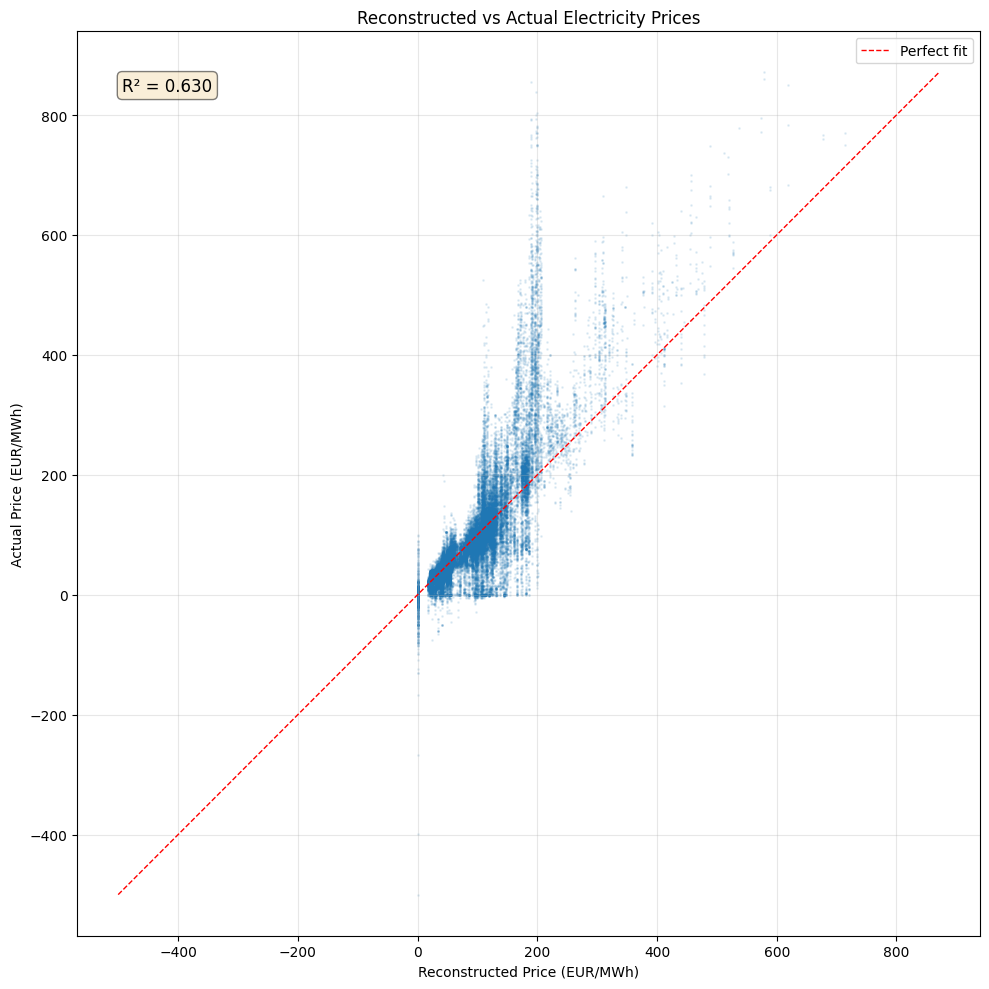

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    sample["price_reconstructed"],
    sample["price"],
    alpha=0.1,
    s=1,
)

# Add 45-degree line
price_range = [
    min(sample["price"].min(), sample["price_reconstructed"].min()),
    max(sample["price"].max(), sample["price_reconstructed"].max()),
]
ax.plot(price_range, price_range, "r--", linewidth=1, label="Perfect fit")

ax.set_xlabel("Reconstructed Price (EUR/MWh)")
ax.set_ylabel("Actual Price (EUR/MWh)")
ax.set_title("Reconstructed vs Actual Electricity Prices")
ax.legend()
ax.grid(True, alpha=0.3)

# Add R² annotation
r2_reconstructed = r2_score(df["price"], df["price_reconstructed"])
ax.text(
    0.05,
    0.95,
    f"R² = {r2_reconstructed:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

fig.tight_layout()
plt.show()

### Residual Load vs Actual Prices

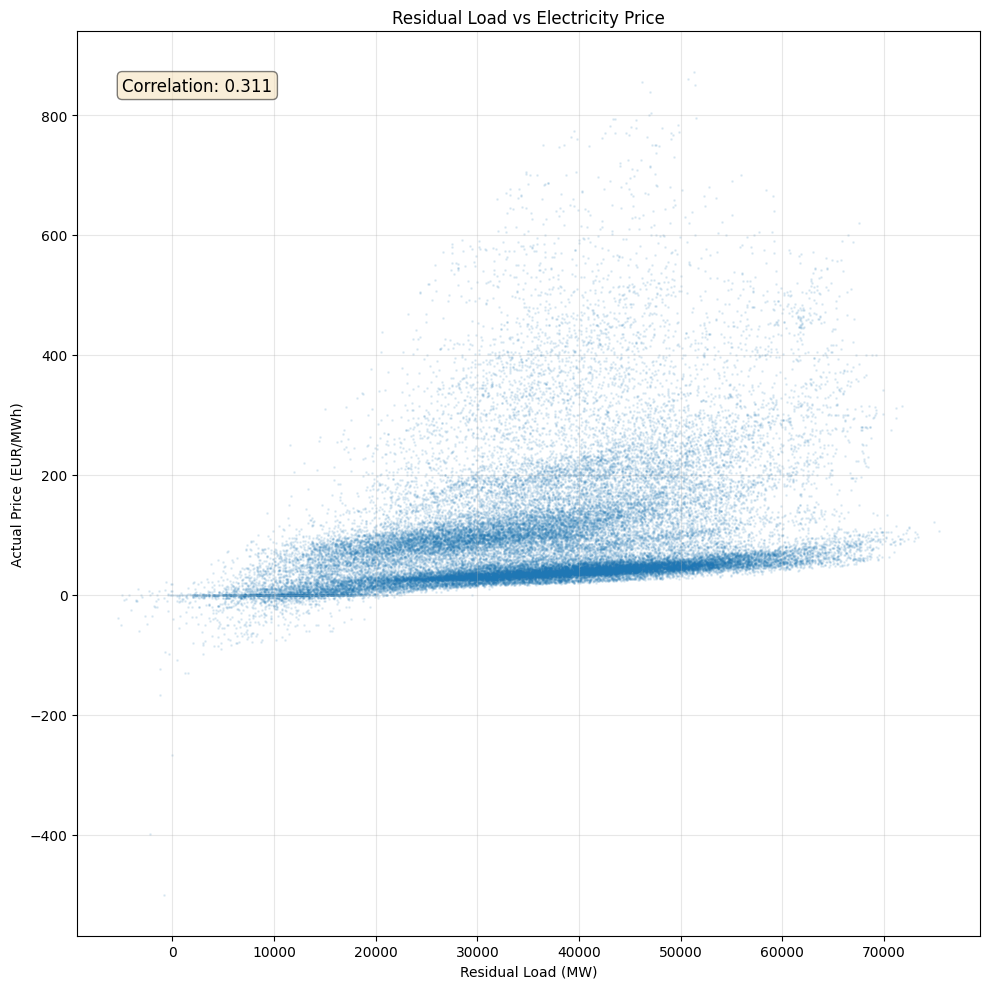

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    sample["residual_load"],
    sample["price"],
    alpha=0.1,
    s=1,
)

ax.set_xlabel("Residual Load (MW)")
ax.set_ylabel("Actual Price (EUR/MWh)")
ax.set_title("Residual Load vs Electricity Price")
ax.grid(True, alpha=0.3)

# Add correlation
corr = df["residual_load"].corr(df["price"])
ax.text(
    0.05,
    0.95,
    f"Correlation: {corr:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

fig.tight_layout()
plt.show()

### Fossil Residual Load vs Actual Prices

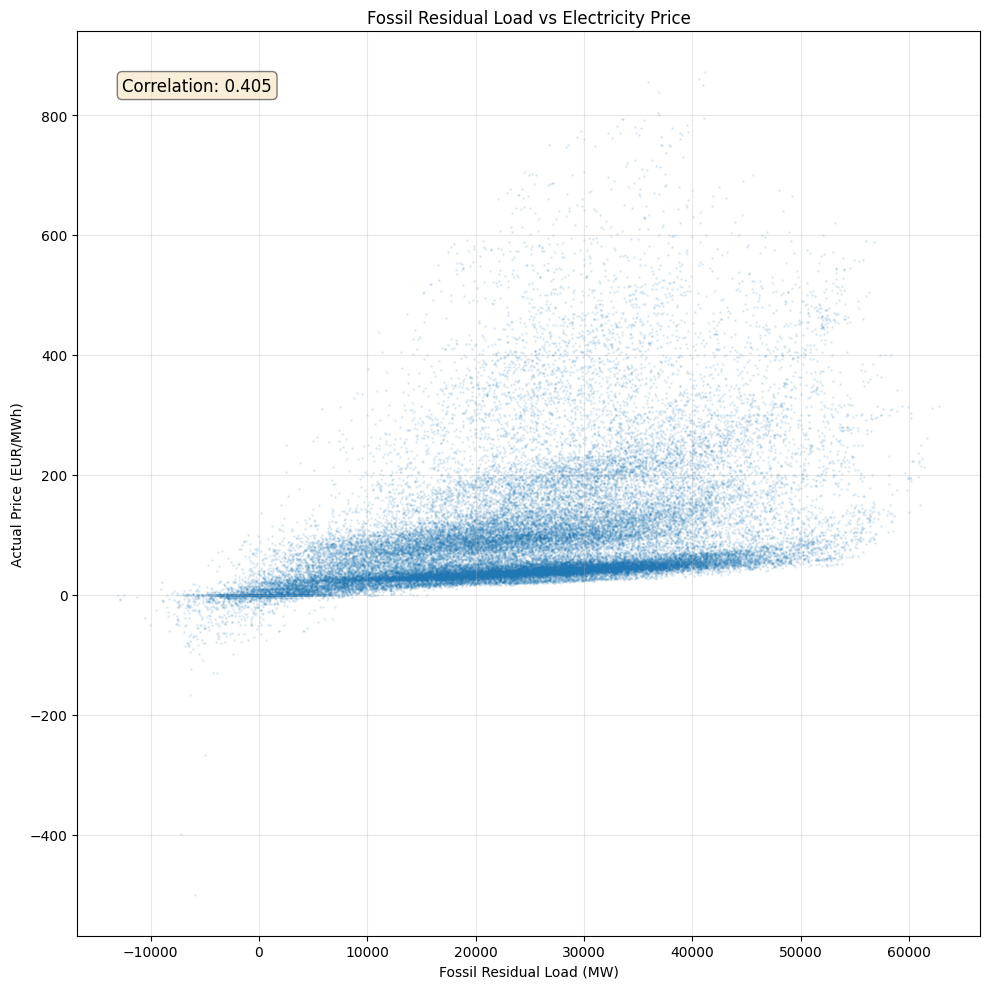

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    sample["rl_fossil"],
    sample["price"],
    alpha=0.1,
    s=1,
)

ax.set_xlabel("Fossil Residual Load (MW)")
ax.set_ylabel("Actual Price (EUR/MWh)")
ax.set_title("Fossil Residual Load vs Electricity Price")
ax.grid(True, alpha=0.3)

# Add correlation
corr_fossil = df["rl_fossil"].corr(df["price"])
ax.text(
    0.05,
    0.95,
    f"Correlation: {corr_fossil:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

fig.tight_layout()
plt.show()

## Variance Explained (R²)

How much of the price variation is explained by each model?

In [23]:
# Prepare data for regression (drop NaN and infinite values)
df_clean = df[["price", "residual_load", "rl_fossil", "price_reconstructed"]].copy()
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna()

X_residual = df_clean[["residual_load"]].values
X_fossil = df_clean[["rl_fossil"]].values
X_reconstructed = df_clean[["price_reconstructed"]].values
y = df_clean["price"].values

# Fit linear models
model_residual = LinearRegression().fit(X_residual, y)
model_fossil = LinearRegression().fit(X_fossil, y)

# Calculate R² scores
r2_residual = model_residual.score(X_residual, y)
r2_fossil = model_fossil.score(X_fossil, y)
r2_reconstructed = r2_score(y, df_clean["price_reconstructed"].values)

print("=" * 60)
print("VARIANCE EXPLAINED (R²)")
print("=" * 60)
print(f"\nResidual Load (linear regression):      R² = {r2_residual:.4f}")
print(f"Fossil Residual Load (linear regression): R² = {r2_fossil:.4f}")
print(f"Reconstructed Prices (merit order model): R² = {r2_reconstructed:.4f}")
print()

VARIANCE EXPLAINED (R²)

Residual Load (linear regression):      R² = 0.0966
Fossil Residual Load (linear regression): R² = 0.1637
Reconstructed Prices (merit order model): R² = 0.6301



## Summary Statistics

In [24]:
# Calculate additional metrics
mae = np.abs(df_clean["price"] - df_clean["price_reconstructed"]).mean()
rmse = np.sqrt(((df_clean["price"] - df_clean["price_reconstructed"]) ** 2).mean())

print("=" * 60)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 60)
print(f"\nMean Absolute Error (MAE):     {mae:.2f} EUR/MWh")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} EUR/MWh")
print(f"\nActual price mean:        {df_clean['price'].mean():.2f} EUR/MWh")
print(f"Reconstructed price mean: {df_clean['price_reconstructed'].mean():.2f} EUR/MWh")
print()

MODEL PERFORMANCE SUMMARY

Mean Absolute Error (MAE):     31.57 EUR/MWh
Root Mean Square Error (RMSE): 62.56 EUR/MWh

Actual price mean:        96.56 EUR/MWh
Reconstructed price mean: 88.10 EUR/MWh



## Comparison Chart: What Explains Price Variation?

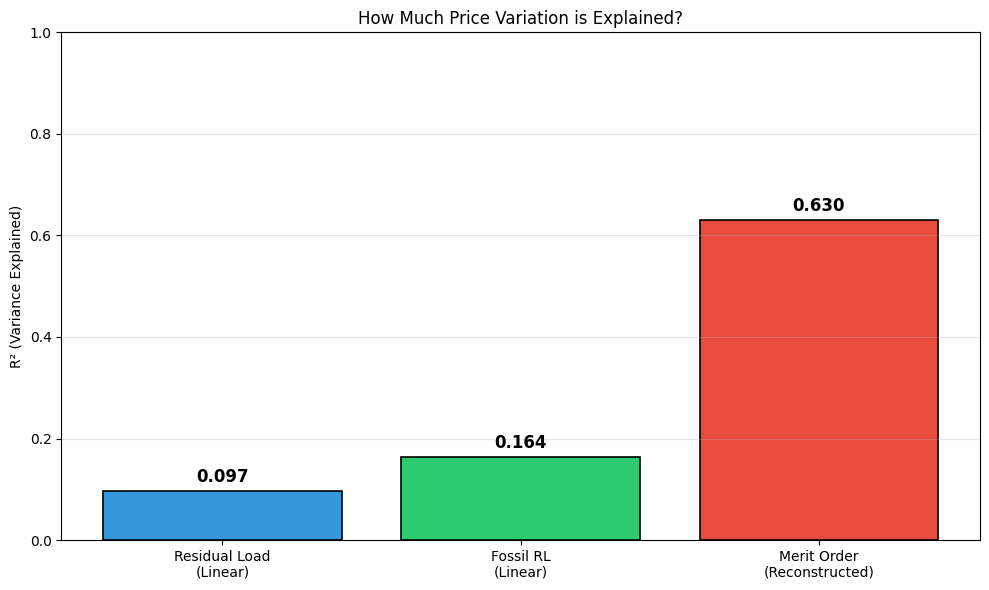

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

models = ["Residual Load\n(Linear)", "Fossil RL\n(Linear)", "Merit Order\n(Reconstructed)"]
r2_values = [r2_residual, r2_fossil, r2_reconstructed]
colors = ["#3498db", "#2ecc71", "#e74c3c"]

bars = ax.bar(models, r2_values, color=colors, edgecolor="black", linewidth=1.2)

# Add value labels on bars
for bar, val in zip(bars, r2_values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

ax.set_ylabel("R² (Variance Explained)")
ax.set_title("How Much Price Variation is Explained?")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis="y")

fig.tight_layout()
plt.show()

In [26]:
from datetime import datetime
from IPython.display import Markdown

Markdown(f"Last run: {datetime.now().strftime('%Y-%m-%d')}")

Last run: 2026-02-08